<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>

# <center> Capstone проект: Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Финальный проект: соревнование Kaggle "Catch Me If You Can"

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
%matplotlib inline

### 1. Подгрузка и описание исходных данных и признаков.

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

train_sessions.csv - обучающая выборка признаки в которой: site_i – индексы посещенных сайтов закодированная словарем site_dic.pkl. Признаки time_i – время посещения сайта i (site_i).

test_df - тестовая выборка аналогична обучающей, но без целевой метки.

<b>Задача бинарной классификации:</b> определить пользователя Элис по сессии (последовательность url ссылок посещенных сайтов пользователем).

Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.

In [3]:
# путь к данным
PATH_TO_DATA = ('./')

In [4]:
# подгружаем данные
time_ = ['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10']

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), 
                       parse_dates = time_, index_col='session_id')

test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      parse_dates = time_, index_col='session_id')

In [5]:
'''обучающая выборка с целевыми метками'''
train_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0


In [6]:
'''тестовая выборка'''
test_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53


### 2. Формирование новых признаков

Объединим обучающую и тестовую выборки. Так удобней сформировать новые признаки и необходимо, чтобы в дальнейшем привести матрицы к разряженной форме.

In [7]:
# Объединим данные train_df и test_df
train_test_df = pd.concat([train_df, test_df])

In [8]:
# train_test_df.head(2)

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.

In [9]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Индексы посещенных сайтов нумеровались с 1, так что заменим пропуски на нули (что касается временных признаков, мы их не будем использовать в чистом виде, а создадим на их основе производные признаки)

In [10]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [11]:
print('объединенная выборка по признакам site_i и с заменой пропусков нулями:')
train_test_df_sites.head()

объединенная выборка по признакам site_i и с заменой пропусков нулями:


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178


В качестве новых признаков сгенерируем: 
1. Продолжительность нахождения на сайте для каждого этапа сессии
2. Число уникальных сайтов в сессии
3. Час начала сессии
4. День недели начала сессии

Новые признаки будем формировать на объединенных данных (train_test_df), посредством следующей функции:

In [12]:
def New_features(data):
    
    time_cols = ['time%d' % i for i in range(1, 11)]
    site_cols = ['site%d' % i for i in range(1, 11)]
    time_diff = []
    unique_sites = []
    start_hour = []
    day_of_week = []
    
    sites = data[site_cols].values.tolist()
    
    for i, (l, time) in tqdm_notebook(enumerate(data[time_cols].iterrows())):
        time_diff.append([0] * (9))
        
        for n in range(9):
            if not pd.isnull(time[n]) and not pd.isnull(time[n+1]):
                time_diff[i][n] = int((time[n+1]-time[n])/np.timedelta64(1, 's'))
        
        start_hour.append(time[0].hour)
        day_of_week.append(time[0].dayofweek)
        
        unique = set(sites[i])
        try:
            unique_sites.remove(0) # remove site '0' from session
        except: 
            pass
        
        unique_sites.append(len(unique))
    
    
    time_diff = np.array(time_diff, dtype='int')                         # продолжительность нахождения на сайте
    unique_sites = np.array(unique_sites).reshape(time_diff.shape[0],1)  # число уникальных сайтов в сессии
    start_hour = np.array(start_hour).reshape(time_diff.shape[0],1)      # час начала сессии
    day_of_week = np.array(day_of_week).reshape(time_diff.shape[0],1)    # день недели начала сессии
    
    data_ = np.hstack((time_diff, unique_sites, start_hour, day_of_week))
    
    columns = ['time_diff' + str(j) for j in range(1,10)] + ['#unique_sites', 'start_hour', 'day_of_week']
    
    data_frame = pd.DataFrame(data_, columns=columns, index=data.index)
    return data_frame

In [75]:
%%time
# получим новые признаки
data_new_features = New_features(train_test_df)

A Jupyter Widget


Wall time: 48min 44s


In [14]:
'''сохраним новые признаки'''
# with open(os.path.join(PATH_TO_DATA, 'New_features.pkl'), 'wb') as pkl:
#     pickle.dump(data_new_features, pkl, protocol=2)

In [15]:
'''загрузка новых признаков'''
with open(os.path.join(PATH_TO_DATA, 'New_features.pkl'), 'rb') as f:
    data_new_features = pickle.load(f)

### 3. Визуализация новых признаков

Распределения новых признаков для всех пользователей (Not Alice) и для Alice имеют различную структуру, особенно признак "час начала сессии", в силу чего данные признаки является информативными.

In [16]:
class_name=dict()
class_name[0]='Not Alice'
class_name[1]='Alice'

color_dic = {0: 'blue', 1: 'red'}

In [17]:
'''временно добавлю поле целевых меток'''
data_new_features['target'] = train_df.target

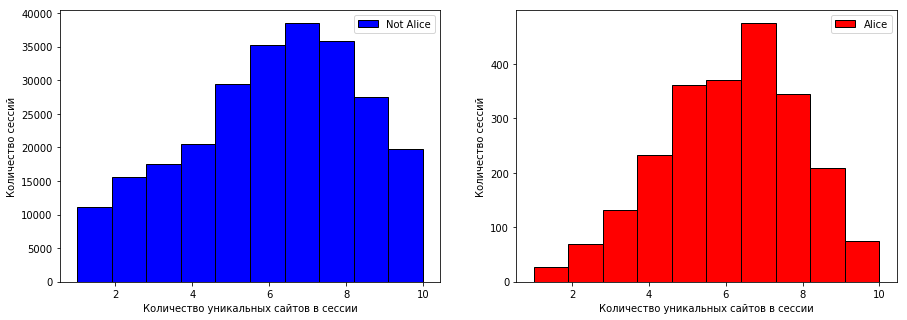

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for idx, (target, sub_df) in enumerate(pd.groupby(data_new_features[:253561], 'target')):
    axes[idx].hist(sub_df['#unique_sites'],color=color_dic[target],edgecolor='black')
    axes[idx].set_xlabel(u'Количество уникальных сайтов в сессии')
    axes[idx].set_ylabel(u'Количество сессий')
    axes[idx].legend([class_name[target]])

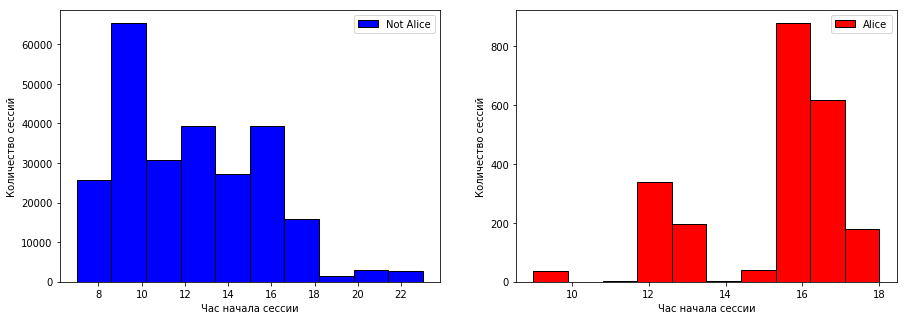

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for idx, (target, sub_df) in enumerate(pd.groupby(data_new_features[:253561], 'target')):
    axes[idx].hist(sub_df['start_hour'],color=color_dic[target],edgecolor='black')
    axes[idx].set_xlabel(u'Час начала сессии')
    axes[idx].set_ylabel(u'Количество сессий')
    axes[idx].legend([class_name[target]])

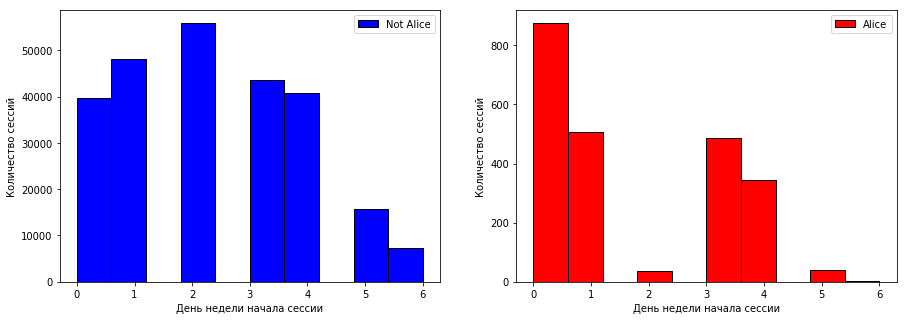

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for idx, (target, sub_df) in enumerate(pd.groupby(data_new_features[:253561], 'target')):
    axes[idx].hist(sub_df['day_of_week'],color=color_dic[target],edgecolor='black')
    axes[idx].set_xlabel(u'День недели начала сессии')
    axes[idx].set_ylabel(u'Количество сессий')
    axes[idx].legend([class_name[target]])

In [21]:
'''удалим поле целевых меток'''
data_new_features.drop('target', axis=1, inplace=True)

### 4. Переход к разряженой форме и прямое кодирование новых признаков

**Переход к разряженной форме для изначальных признаков**

После того как мы объединили обучающую и тестовую выборки а так же сформировали новые признаки, необходимо перейти к разряженой форме:

In [22]:
# функция Матрица преобразований в разряженую форму
def Csr_Matrix(sessions):
    
    # выпишем таблицу сайтов по сессим (sessions) в одну последовательность:
    indices = list(np.array(sessions).reshape((1,sessions.size))[0])
    # список единиц, размер совпадает с количеством всех открытых сайтов в таблице сессий (sessions):
    data = list(np.ones(sessions.size, dtype=int))
    # список в котором каждый индекс равен количеству всех предыдущих элементов (кол. таких индексов = кол. сессий)
    indptr = [sessions.shape[1]*k for k in range(len(sessions)+1)]

    return csr_matrix((data, indices, indptr), dtype=int)[:,1:]

Начнем обработку с объединенной исходной выборки (train_test_df_sites):

In [23]:
# преобразование в разряженную форму 
train_test_sparse = Csr_Matrix(train_test_df_sites.values)

In [24]:
print('Размер разряженной матрицы: {}'.format(train_test_sparse.get_shape()))

Размер разряженной матрицы: (336358, 48371)


**Прямое кодирование новых признаков**

Теперь преобразуем наши новые признаки (data_new_features) посредством прямого кодирования (с одним горячим состоянием):

In [25]:
data_variables = pd.get_dummies(data_new_features, columns=['#unique_sites', 'start_hour', 'day_of_week'],
                                        sparse=True, drop_first=True)

In [26]:
data_variables.columns

Index(['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9',
       '#unique_sites_2', '#unique_sites_3', '#unique_sites_4',
       '#unique_sites_5', '#unique_sites_6', '#unique_sites_7',
       '#unique_sites_8', '#unique_sites_9', '#unique_sites_10',
       'start_hour_8', 'start_hour_9', 'start_hour_10', 'start_hour_11',
       'start_hour_12', 'start_hour_13', 'start_hour_14', 'start_hour_15',
       'start_hour_16', 'start_hour_17', 'start_hour_18', 'start_hour_19',
       'start_hour_20', 'start_hour_21', 'start_hour_22', 'start_hour_23',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6'],
      dtype='object')

Получим матрицу значений данных признаков

In [27]:
matrix_feature = data_variables.values

In [28]:
matrix_feature.shape

(336358, 40)

**Нормализация новых признаков**

Сразу нормализовать признаки не есть хорошо, т.к. во время кросс-валидации будет утечка информации, однако мы будем переходить в разряженную форму и конвеер (pipeline) не сможет запомнить нужные поля для нормализации

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [30]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
features_scal = scaler.fit_transform(matrix_feature)

**Объединим исходные разряженные матрицы с нашими новыми признаками**

In [31]:
'''объединим в разряженной форме'''
_sparse_ = hstack([train_test_sparse, features_scal]).tocsr()

Теперь можно разделить выборку на обучение (с целевыми метками) и тест

In [36]:
X_train_sparse = _sparse_[:train_df.shape[0]]
X_test_sparse = _sparse_[train_df.shape[0]:]
y = train_df['target']

### 5. Построение модели и подбор параметров

In [44]:
%%time
sgd_logit = SGDClassifier(random_state=0, loss='log')
cv = cross_val_score(sgd_logit, X_train_sparse, y, cv=5, scoring='roc_auc')
print(cv.mean(), cv.std())

0.975323776856 0.00241403525523
Wall time: 6.88 s


In [45]:
%%time
sgd_svc = SGDClassifier(random_state=0, loss='hinge')
cv = cross_val_score(sgd_svc, X_train_sparse, y, cv=5, scoring='roc_auc')
print(cv.mean(), cv.std())

0.972589623159 0.00298090642342
Wall time: 5.28 s


**Подберем параметры классификатора сеткой**

In [60]:
%%time
sgd_logit = SGDClassifier(random_state=0, n_jobs=-1, loss='log')

params = {'alpha': [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000],
          'penalty': ['l1','l2']}
grid_1 = GridSearchCV(sgd_logit, params, cv=5, scoring='roc_auc')
grid_1.fit(X_train_sparse, y)

Wall time: 3min 49s


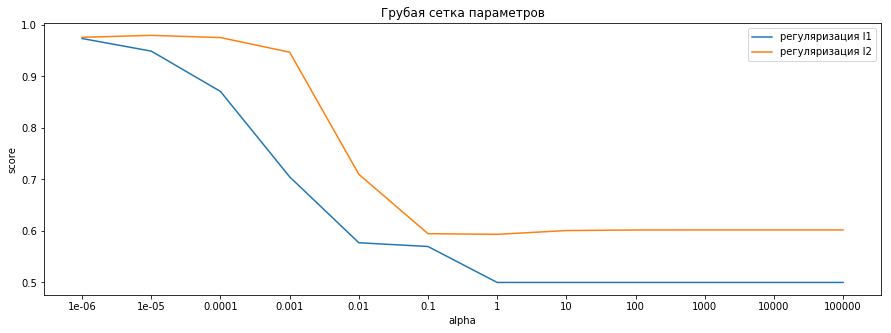

In [141]:
'''параметры'''
score_l1 = list(pd.Series(grid_1.cv_results_).mean_test_score[::2])
score_l2 = list(pd.Series(grid_1.cv_results_).mean_test_score[1::2])
param = list(pd.Series(grid_1.cv_results_).param_alpha[::2])

plt.figure(figsize=(15,5))
plt.title('Грубая сетка параметров')
plt.plot(range(len(score_l1)), score_l1, label='регуляризация l1')
plt.plot(range(len(score_l2)), score_l2, label='регуляризация l2')
plt.xticks(range(len(score_l1)), param)
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend()
plt.show()

In [138]:
%%time
sgd_logit = SGDClassifier(random_state=0, n_jobs=-1, loss='log')

params = {'alpha': np.linspace(1e-08,1e-03, 30),
          'penalty': ['l1','l2']}
grid_2 = GridSearchCV(sgd_logit, params, cv=5, scoring='roc_auc')
grid_2.fit(X_train_sparse, y)

Wall time: 9min 55s


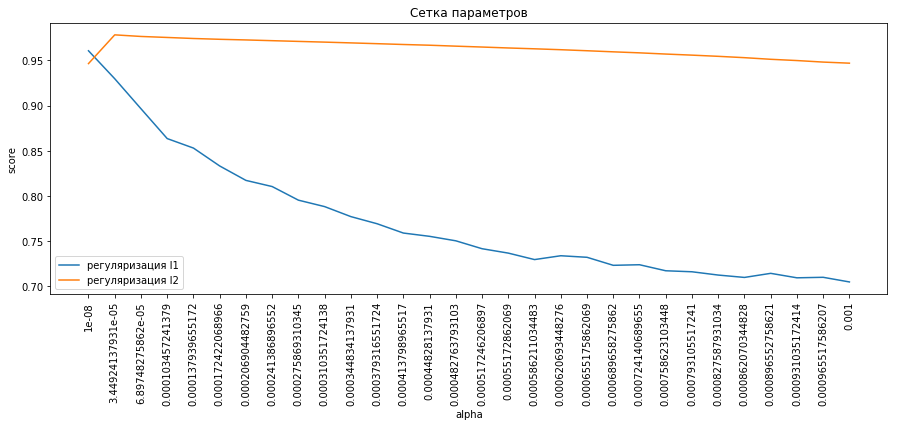

In [145]:
'''параметры'''
score_l1 = list(pd.Series(grid_2.cv_results_).mean_test_score[::2])
score_l2 = list(pd.Series(grid_2.cv_results_).mean_test_score[1::2])
param = list(pd.Series(grid_2.cv_results_).param_alpha[::2])

plt.figure(figsize=(15,5))
plt.title('Сетка параметров')
plt.plot(range(len(score_l1)), score_l1, label='регуляризация l1')
plt.plot(range(len(score_l2)), score_l2, label='регуляризация l2')
plt.xticks(range(len(score_l1)), param, rotation='vertical')
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend()
plt.show()

In [151]:
# лучшая оценка
grid_2.best_score_

0.97825309918246328

In [157]:
# лучшие параметры модели
grid_2.best_params_

{'alpha': 3.4492413793103455e-05, 'penalty': 'l2'}

In [158]:
# получаем метки на тестовой выборке
logit_test_pred_proba = grid_2.best_estimator_.predict_proba(X_test_sparse)[:,1]

Добавляем результаты в файл (результат на тесте kaggle: 0.95545)

In [160]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [162]:
write_to_submission_file(logit_test_pred_proba, 'ADN-log.csv')